In [1]:
import os, sys
sys.path.append('../../')
from os.path import abspath, dirname
import zarr
import z5py
import numpy as np
import pandas as pd
from glob import glob 
from skimage.measure import regionprops
from skimage.io import imread, imsave
from scipy import stats
from scipy.stats import skewnorm, lognorm
from scipy.optimize import minimize
import itertools
import collections

from easi_fish import n5_metadata_utils as n5mu
from easi_fish import roi_prop, spot, intensity
import warnings
warnings.filterwarnings('ignore')

import importlib
importlib.reload(spot)
importlib.reload(roi_prop)
importlib.reload(intensity)

<module 'easi_fish.intensity' from '/u/project/zipursky/f7xiesnm/code/easifish-proc/bydatasets/lt185/../../easi_fish/intensity.py'>

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

sns.set_style('white', rc={'axes.grid':True})
sns.set_context('talk')

Spot counts for cells with highly expressed genes (dense spots)
1. Measure total intensity of every ROI after bleed-through correction and background subtraction.
2. Calculate the number of spot from total intensity based on unit-spot intensity
3. Correlate the number of spots (from air-localize) with the total fluorescence intensity/voxel in each ROI and determine a 'cutoff'. 
   Spot count > cutoff: use spot count converted based on total fluorescence intensity; 
   Spot count < cutoff: use spot count from Airlocalize

### On units
- all images are based on pixel units - 
- roi meta file (output) are based on physical unit (um - pre-expansion)
- spots files are in um (post-expansion)

In [4]:
## input

# theround = 'r2'
# rounds = [theround]
# channels = ['c0', 'c1', 'c2', 'c4']

ddir = '/u/home/f/f7xiesnm/project-zipursky/easifish/lt185'
output_dir = ddir + '/proc/r2-v2'

fix_round = 'r2v2'
# mov_rounds = ['r2', 'r6', 'r7']
mov_rounds = []
round_channels = collections.OrderedDict({
    'r2v2': ('c0', 'c1', 'c2', 'c4'),
})

dapi_channel = 'c3'
lb_scale = 's3'
lb_res = [1.84,1.84,1.68]
ex = 2

# images
fix_dir  =  ddir + f"/outputs/{fix_round}/stitching/export.n5"
lb_dir  =   ddir + f"/outputs/{fix_round}/segmentation/{fix_round}-{dapi_channel}.tif"
reg_dirs = [
    # ddir + f"/outputs/r2/registration/usable/r2-to-r1/warped",
    # ddir + f"/outputs/r7/registration/usable/r7-to-r1/warped",
    ]
subpath =   f'/{dapi_channel}/{lb_scale}' 


# spot dir for every gene
# fx_spots = np.hstack([[ddir + f'/outputs/{r}/spots/spots_{c}.txt' 
#                         for c in chs]
#                         for r,chs in round_channels.items()])

# fx_intns = np.hstack([[ddir + f'/outputs/{r}/intensities/{r}_{c}_intensity.csv' 
#                         for c in chs]
#                         for r,chs in round_channels.items()])

fx_spots = [
    ddir + f'/outputs/r2v2/spots/spots_c0.txt',
    ddir + f'/outputs/r2v2/spots/spots_c1.txt',
    ddir + f'/outputs/r2v2/spots/spots_c2.txt',
    ddir + f'/outputs/r2v2/spots/spots_c4.txt',
    
#     ddir + f'/outputs/r2/spots/r2-to-r1-v2/spots_c0-warped.txt',
#     ddir + f'/outputs/r2/spots/r2-to-r1-v2/spots_c1-warped.txt',
#     ddir + f'/outputs/r2/spots/r2-to-r1-v2/spots_c2-warped.txt',
#     ddir + f'/outputs/r2/spots/r2-to-r1-v2/spots_c4-warped.txt',
    
#     ddir + f'/outputs/r6/spots/r6-to-r2-to-r1-v2/spots_c0-warped-warped.txt',
#     ddir + f'/outputs/r6/spots/r6-to-r2-to-r1-v2/spots_c1-warped-warped.txt',
#     ddir + f'/outputs/r6/spots/r6-to-r2-to-r1-v2/spots_c2-warped-warped.txt',
#     ddir + f'/outputs/r6/spots/r6-to-r2-to-r1-v2/spots_c4-warped-warped.txt',
    
#     ddir + f'/outputs/r7/spots/r7-to-r1-v2/spots_c0-warped.txt',
#     ddir + f'/outputs/r7/spots/r7-to-r1-v2/spots_c1-warped.txt',
#     ddir + f'/outputs/r7/spots/r7-to-r1-v2/spots_c2-warped.txt',
#     ddir + f'/outputs/r7/spots/r7-to-r1-v2/spots_c4-warped.txt',
]

# fx_intns = [
#     ddir + f'/outputs/r1/intensities/r1_c0_intensity.csv',
#     ddir + f'/outputs/r1/intensities/r1_c2_intensity.csv',
    
#     ddir + f'/outputs/r2/intensities/r2-to-r1/r2-to-r1_c0_intensity.csv',
#     ddir + f'/outputs/r2/intensities/r2-to-r1/r2-to-r1_c1_intensity.csv',
#     ddir + f'/outputs/r2/intensities/r2-to-r1/r2-to-r1_c2_intensity.csv',
#     ddir + f'/outputs/r2/intensities/r2-to-r1/r2-to-r1_c4_intensity.csv',
# ]

intn_threshs = [
    # 150, 
    # 150, 
    
    10, # 20, # 110-90,
    20, # 50, # 200-90, #
    10, # 20, # 110-90,
    10, # 20, # 110-90, 
    
#     110,
#     200, #
#     110,
#     110, 
    
#     110,
#     200, #
#     110,
#     110, 
]
    
for f in fx_spots:
    assert os.path.isfile(f)
# for f in fx_intns:
#     assert os.path.isfile(f)

## output
out_badroi = os.path.join(output_dir, 'bad_roi_list.npy')
out_allroi = os.path.join(output_dir, "roi_all.csv") 
out_roi = os.path.join(output_dir, "roi.csv") 
out_spots = os.path.join(output_dir, "spotcount.csv")

# out_spots_intn = os.path.join(output_dir, "spotcount_intn.csv")
# out_spots_merged = os.path.join(output_dir, 'spotcount_merged.csv')

In [5]:
REMOVE_BLEEDTHRU = False

# remove bleed through!
if REMOVE_BLEEDTHRU:
    
    bleed_thru_epsilon = 1
    c_qry = 'c0'
    c_ref = 'c4'

    f_ref = ddir+f'/outputs/{theround}/spots/spots_{c_ref}.txt'
    f_qry = ddir+f'/outputs/{theround}/spots/spots_{c_qry}.txt'
    f_qry_kept = os.path.join(output_dir, f'kept_spots_{theround}_{c_qry}.txt')

    ref_dots = np.loadtxt(f_ref, delimiter=',')
    qry_dots = np.loadtxt(f_qry, delimiter=',')
    qry_kept, qry_removed = spot.remove_bleed_thru_spots(ref_dots, qry_dots, epsilon=bleed_thru_epsilon)

    # save 
    np.savetxt(f_qry_kept, qry_kept, delimiter=",")
    
    ### TODO - replace f_qry with f_qry_kept in spot list

In [6]:
%%time
# output dir
if not os.path.isdir(output_dir):
    print(output_dir)
    os.mkdir(output_dir)
    
# image size in pixel (x, y, z)
grid = n5mu.read_voxel_grid(fix_dir, subpath)
# voxel resolution in µm (x, y, z) (post-expansion)
vox  = n5mu.read_voxel_spacing(fix_dir, subpath)
# image size in physical space (x, y, z) (post-expansion)
size = grid*vox
print('subpath: ', subpath)
print('voxel size: ', vox)
print('image size (pixel): ', grid)
print('image size (um post-ex): ', size)

# get image data
# print("loading images...")
# fix = zarr.open(store=zarr.N5Store(fix_dir), mode='r')     
# img1 = fix[subpath][:, :, :]

# get segmentation mask
lb = imread(lb_dir)
# roi = np.max(lb) # this is only correct if this lb is uncropped
roi = len(np.unique(lb[lb!=0])) # this would be better
print(lb.shape)
print('num roi: ', roi)

subpath:  /c3/s3
voxel size:  [1.84 1.84 1.68]
image size (pixel):  [1123  902  676]
image size (um post-ex):  [2066.32   1659.68   1135.6799]
(676, 902, 1123)
num roi:  44672
CPU times: user 9.06 s, sys: 3.75 s, total: 12.8 s
Wall time: 9.61 s


In [7]:
# %%time
# bad_roi = []
# for reg_dir in reg_dirs:
#     reg = zarr.open(store=zarr.N5Store(reg_dir), mode='r')     
#     img2 = reg[subpath][...]
#     print("image loaded")
    
#     # get bad pixels -> bad roi
#     bad_roi_thisround = np.unique(lb[np.nonzero(img2==0)])
#     bad_roi.append(bad_roi_thisround)
#     print("# of ROIs rejected this round:", len(bad_roi_thisround))
    
# bad_roi = np.unique(np.hstack(bad_roi))
# print("# of ROIs rejected:", len(bad_roi))
# bad_roi

In [8]:
# lb

In [9]:
%%time
# # Get list of ROIs that are fully or partially outside the mask 
### Make sure to only include ROIs that are intact and in the overlapping regions across all rounds of FISH
### remove any unregistered parts
mask = np.ones(grid[::-1])
if len(reg_dirs) > 0:
    for reg_dir in reg_dirs:
        reg = zarr.open(store=zarr.N5Store(reg_dir), mode='r')     
        img2 = reg[subpath][...]
        print("image loaded")
        mask[img2==0]=0
    print("mask generated")

    bad_roi = np.unique(lb[mask==0])
    if bad_roi[0] == 0: # remove the label 0 - extracellular space
        bad_roi = bad_roi[1:]
    np.save(out_badroi, bad_roi)
    print("# of ROIs rejected:", len(bad_roi))

CPU times: user 504 ms, sys: 2.38 s, total: 2.88 s
Wall time: 2.89 s


In [10]:
%%time
# get cell locations (in um - pre-expansion) from segmentation mask
roi_meta_all = roi_prop.roi_prop_v2(lb, lb_res, ex)
roi_meta_all.to_csv(out_allroi)

roi_meta = roi_meta_all.set_index('roi').copy()
roi_meta = roi_meta #.loc[roi_meta.index.difference(bad_roi)]
roi_meta.to_csv(out_roi)

CPU times: user 19.1 s, sys: 2.77 s, total: 21.8 s
Wall time: 21.9 s


In [11]:
%%time

# count spots for every cell (roi)

# all labels
lb_id = np.unique(lb[lb!=0]) # exclude 0
lb_id = np.hstack([[0], lb_id]) # include 0 - noncell
# selected cells
lb_id_selected = roi_meta.index.values

# prep
spotcount = pd.DataFrame(index=lb_id_selected, dtype=int)
# spotcount_intn = pd.DataFrame(index=lb_id_selected, dtype=float)

i = 0
for r,chs in round_channels.items():
    for c in chs:
        # f_intns = fx_intns[i]
        f_spots = fx_spots[i]
        intn_th = intn_threshs[i]
        print(r, c, f_spots) #, f_intns)

        # spots
        spots_rc = np.loadtxt(f_spots, delimiter=',')
        print(len(spots_rc))

        # filter
        filter_cond = spots_rc[:,3] > intn_th
        spots_rc = spots_rc[filter_cond]
        print(len(spots_rc))

        # count spots
        res = spot.spot_counts_worker(lb, spots_rc, lb_res,
                                      lb_id=lb_id, 
                                      remove_noncell=True, 
                                      selected_roi_list=lb_id_selected,
                                      )
        spotcount[f"{r}_{c}"] = res 

        # # count spots by intensity
        # res = spot.get_spot_counts_from_intn(f_intns, f_spots, roi_meta, lb_res)
        # spotcount_intn[f'{r}_{c}'] = res
        i = i + 1
    
# save results
spotcount.to_csv(out_spots)
# spotcount_intn.to_csv(out_spots_intn)

r2v2 c0 /u/home/f/f7xiesnm/project-zipursky/easifish/lt185/outputs/r2v2/spots/spots_c0.txt
99124
98200
removed 0 spots due to nan
98,190/98,200 spots in range (1123, 902, 676)
r2v2 c1 /u/home/f/f7xiesnm/project-zipursky/easifish/lt185/outputs/r2v2/spots/spots_c1.txt
1537841
1482058
removed 0 spots due to nan
1,461,489/1,482,058 spots in range (1123, 902, 676)
r2v2 c2 /u/home/f/f7xiesnm/project-zipursky/easifish/lt185/outputs/r2v2/spots/spots_c2.txt
111074
108577
removed 0 spots due to nan
108,457/108,577 spots in range (1123, 902, 676)
r2v2 c4 /u/home/f/f7xiesnm/project-zipursky/easifish/lt185/outputs/r2v2/spots/spots_c4.txt
245321
236204
removed 0 spots due to nan
236,191/236,204 spots in range (1123, 902, 676)
CPU times: user 13.5 s, sys: 1.17 s, total: 14.7 s
Wall time: 14.7 s


In [12]:
# # reconcile two spot counts
# dist_cutoff = 2 # um pre-expansion
# density = spotcount.divide(roi_meta['area'], axis=0)
# cond = density < 1/(dist_cutoff**3) # keep spots if density is low

# print("# cells have high density: ", (~cond).sum()) 
# spotcount_merged = spotcount.where(cond, spotcount_intn)  # replace where the condition is False
# spotcount_merged.to_csv(out_spots_merged)
# spotcount_merged

# check - c0

In [13]:
def plot_reverse_cumsum(counts, bins=np.arange(0,11,1), ymax=None):
    """
    """
    fig, ax = plt.subplots(figsize=(8,6))
    ax2 = ax.twinx()
    ax.set_xlabel('num spots')
    ax.set_ylabel('num cells (cumulative)')
    ax2.set_ylabel('fraction of cells')
    
    n = len(counts)
    cnts, _ = np.histogram(counts, bins)
    rev_cumsum = n-np.cumsum(cnts)
        
    ax.plot(bins[1:], rev_cumsum, '-o', )
    ax2.plot(bins[1:], rev_cumsum/n, '-o', )
    
    if ymax:
        ax.set_ylim(ymin=0, ymax=ymax)
        ax2.set_ylim(ymin=0, ymax=ymax/n)
        
    ax.grid(False)
    ax2.grid(False)
    
    return fig

def plot_reverse_cumsum_complex(counts_list, label_list=None, color_list=None, bins=np.arange(0,11,1), ymax=None):
    """
    """
    fig, axs = plt.subplots(1,2,figsize=(2*8,6))
    ax = axs[0]
    ax2 = ax.twinx()
    ax.set_xlabel('num spots')
    ax.set_ylabel('num cells (cumulative)')
    ax2.set_ylabel('fraction of cells')
    
    if label_list is None:
        label_list = np.arange(len(counts_list))
    if color_list is None:
        color_list = sns.color_palette(n_colors=3)
        
    cumsum_list = []
    n = len(counts_list[0])
    for counts in counts_list:
        assert n == len(counts) # assumes len(counts) is the same
        cnts, _ = np.histogram(counts, bins)
        rev_cumsum = n-np.cumsum(cnts)
        cumsum_list.append(rev_cumsum)
        
    for revcnts, lb, color in zip(cumsum_list, label_list, color_list):
        ax.plot(bins[1:], revcnts, '-o', label=lb, color=color)
        ax2.plot(bins[1:], revcnts/n, '-o', label=lb, color=color)
    
    if ymax:
        ax.set_ylim(ymin=0, ymax=ymax)
        ax2.set_ylim(ymin=0, ymax=ymax/n)
        
    ax.grid(False)
    ax2.grid(False)
    
    ax = axs[1]
    lb = label_list[1]
    color = color_list[1]
    ax.plot(bins[1:], cumsum_list[1]/cumsum_list[0], '-o', label=lb, color=color)
    
    lb = label_list[2]
    color = color_list[2]
    ax.plot(bins[1:], cumsum_list[2]/cumsum_list[0], '-o', label=lb, color=color)
    ax.set_yscale('log')
    ax.set_yticks([1,0.1,0.05,0.01])
    ax.set_yticklabels([1,0.1,0.05, 0.01])
    ax.set_ylabel('eFDR (shuff/data)')
    
    fig.subplots_adjust(wspace=0.4)
    
    return fig, axs

def plot_frac(data, shff, bins=np.arange(0,11,1)):
    """
    """
    fig, ax = plt.subplots()
    
    cnts_data, bins = np.histogram(data, bins)
    cnts_shff, bins = np.histogram(shff, bins)
    
    ax.plot(bins[1:], cnts_shff/cnts_data, '-o')
    ax.set_yscale('log')
    ax.set_yticks([1,0.1,0.05,0.01])
    ax.set_yticklabels([1,0.1,0.05, 0.01])
    
    return fig

In [14]:
i = 0
c = chs[i]
f_spots = fx_spots[i]
intn_th = intn_threshs[i]
print(r, c, f_spots) #, f_intns)

# spots
spots_rc = np.loadtxt(f_spots, delimiter=',')
print(len(spots_rc))

# filter
filter_cond = spots_rc[:,3] > intn_th
spots_rc = spots_rc[filter_cond]
print(len(spots_rc))

r2v2 c0 /u/home/f/f7xiesnm/project-zipursky/easifish/lt185/outputs/r2v2/spots/spots_c0.txt
99124
98200


In [15]:
spots = np.round(spots_rc[:,:3]/lb_res).astype(int)-1
spots_lb = lb[spots[:,2], spots[:,1], spots[:,0]] # z, y, x
spots_lb_outside = (spots_lb == 0)
print(f"fraction of spots outside of cells: {spots_lb_outside.sum()/len(spots):.2f}")
print(f"fraction of space outside of cells: {np.sum(lb==0)/lb.size:.2f}")

fraction of spots outside of cells: 0.19
fraction of space outside of cells: 0.78


In [16]:
%%time
# shuffle everywhere
lb_shuff = lb.copy()
np.random.shuffle(np.ravel(lb_shuff))
lb_shuff = lb_shuff.reshape(lb.shape)

CPU times: user 49.9 s, sys: 1.79 s, total: 51.7 s
Wall time: 51.6 s


In [17]:
%%time
# shuffle in cells
i, j, k = lb.nonzero()
v = lb[i,j,k]
np.random.shuffle(v)
lb_shuff2 = np.zeros(lb.shape)
lb_shuff2[i,j,k] = v

CPU times: user 17.4 s, sys: 4.94 s, total: 22.3 s
Wall time: 22.3 s


In [18]:
res        = spot.spot_counts_worker(lb, spots_rc, lb_res,
                              lb_id=lb_id, 
                              remove_noncell=True, 
                              selected_roi_list=lb_id_selected,
                              )
res_shuff  = spot.spot_counts_worker(lb_shuff, spots_rc, lb_res,
                              lb_id=lb_id, 
                              remove_noncell=True, 
                              selected_roi_list=lb_id_selected,
                              )
res_shuff2 = spot.spot_counts_worker(lb_shuff2, spots_rc, lb_res,
                              lb_id=lb_id, 
                              remove_noncell=True, 
                              selected_roi_list=lb_id_selected,
                              )

removed 0 spots due to nan
98,190/98,200 spots in range (1123, 902, 676)
removed 0 spots due to nan
98,190/98,200 spots in range (1123, 902, 676)
removed 0 spots due to nan
98,190/98,200 spots in range (1123, 902, 676)


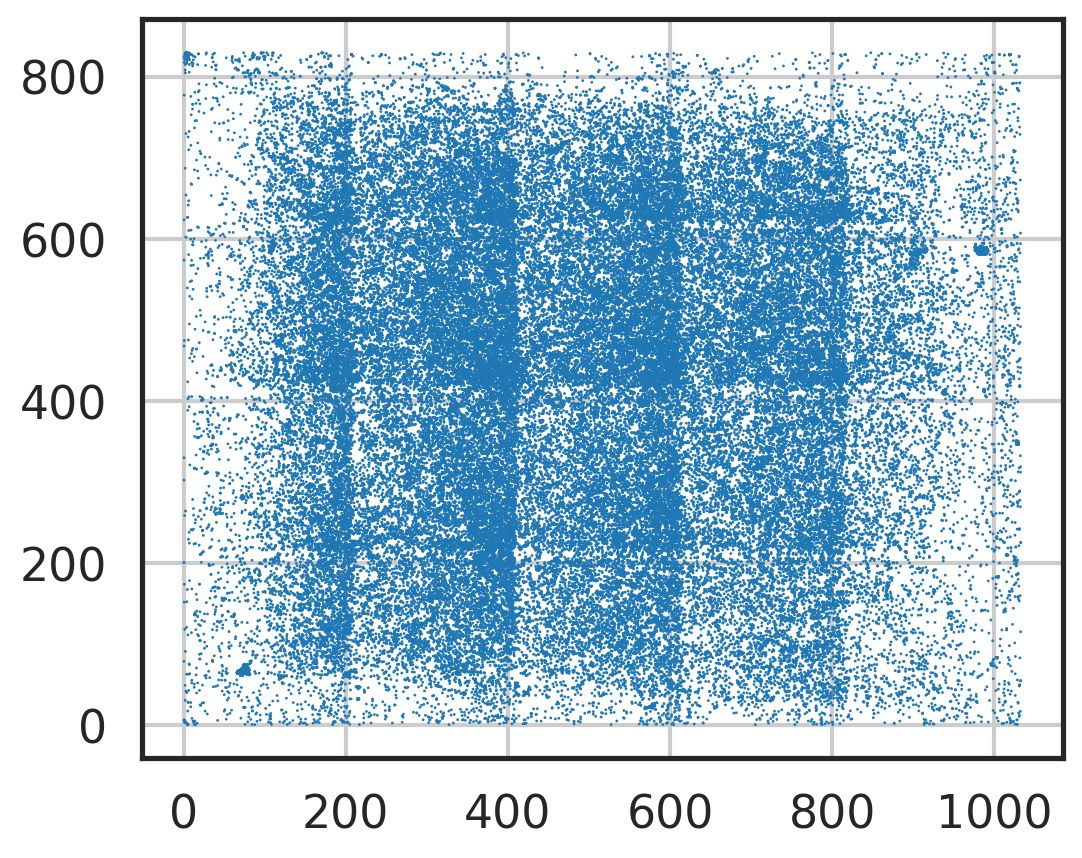

In [19]:
plt.scatter(spots_rc[:,0]/ex, spots_rc[:,1]/ex, s=1, edgecolor='none')
plt.gca().set_aspect('equal')

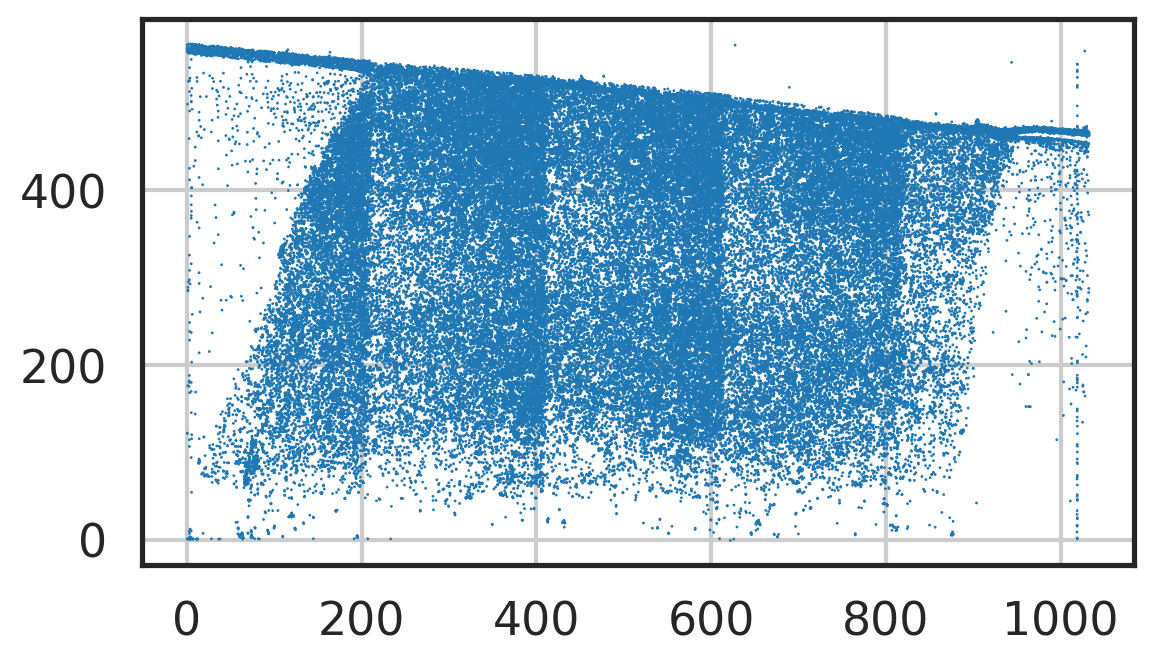

In [20]:
plt.scatter(spots_rc[:,0]/ex, spots_rc[:,2]/ex, s=1, edgecolor='none')
plt.gca().set_aspect('equal')

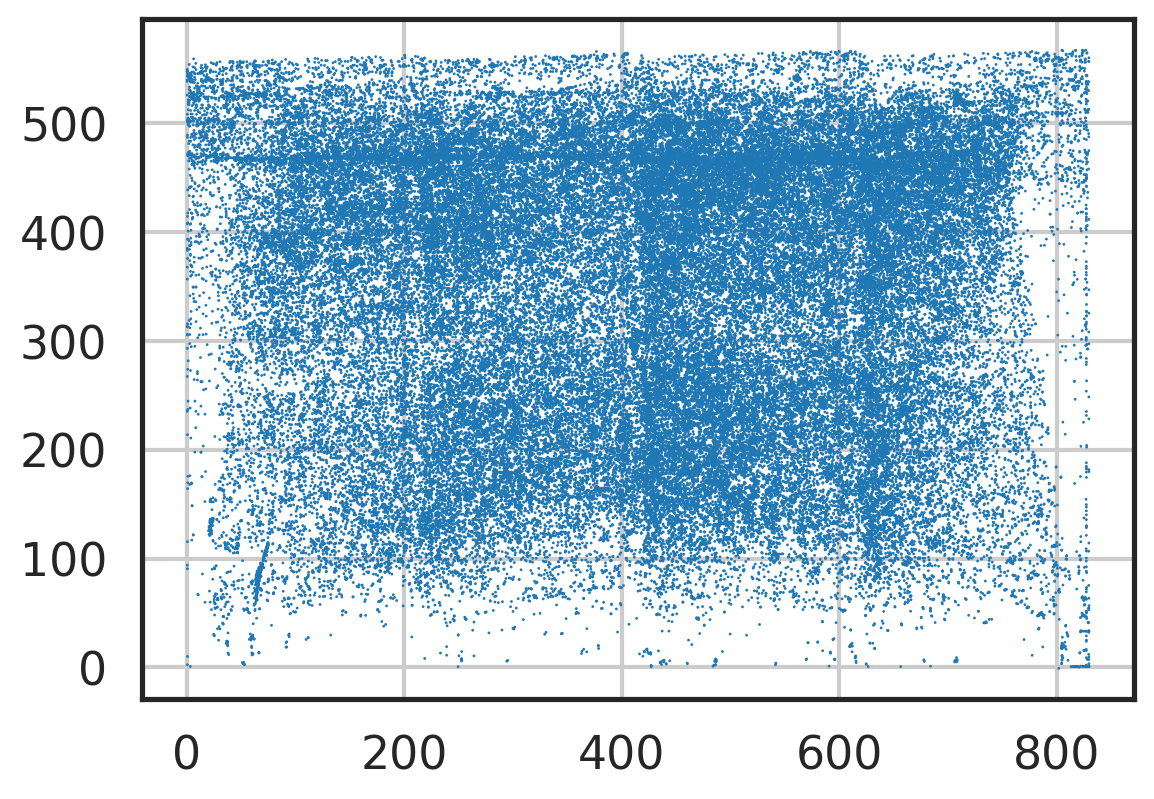

In [21]:
plt.scatter(spots_rc[:,1]/ex, spots_rc[:,2]/ex, s=1, edgecolor='none')
plt.gca().set_aspect('equal')

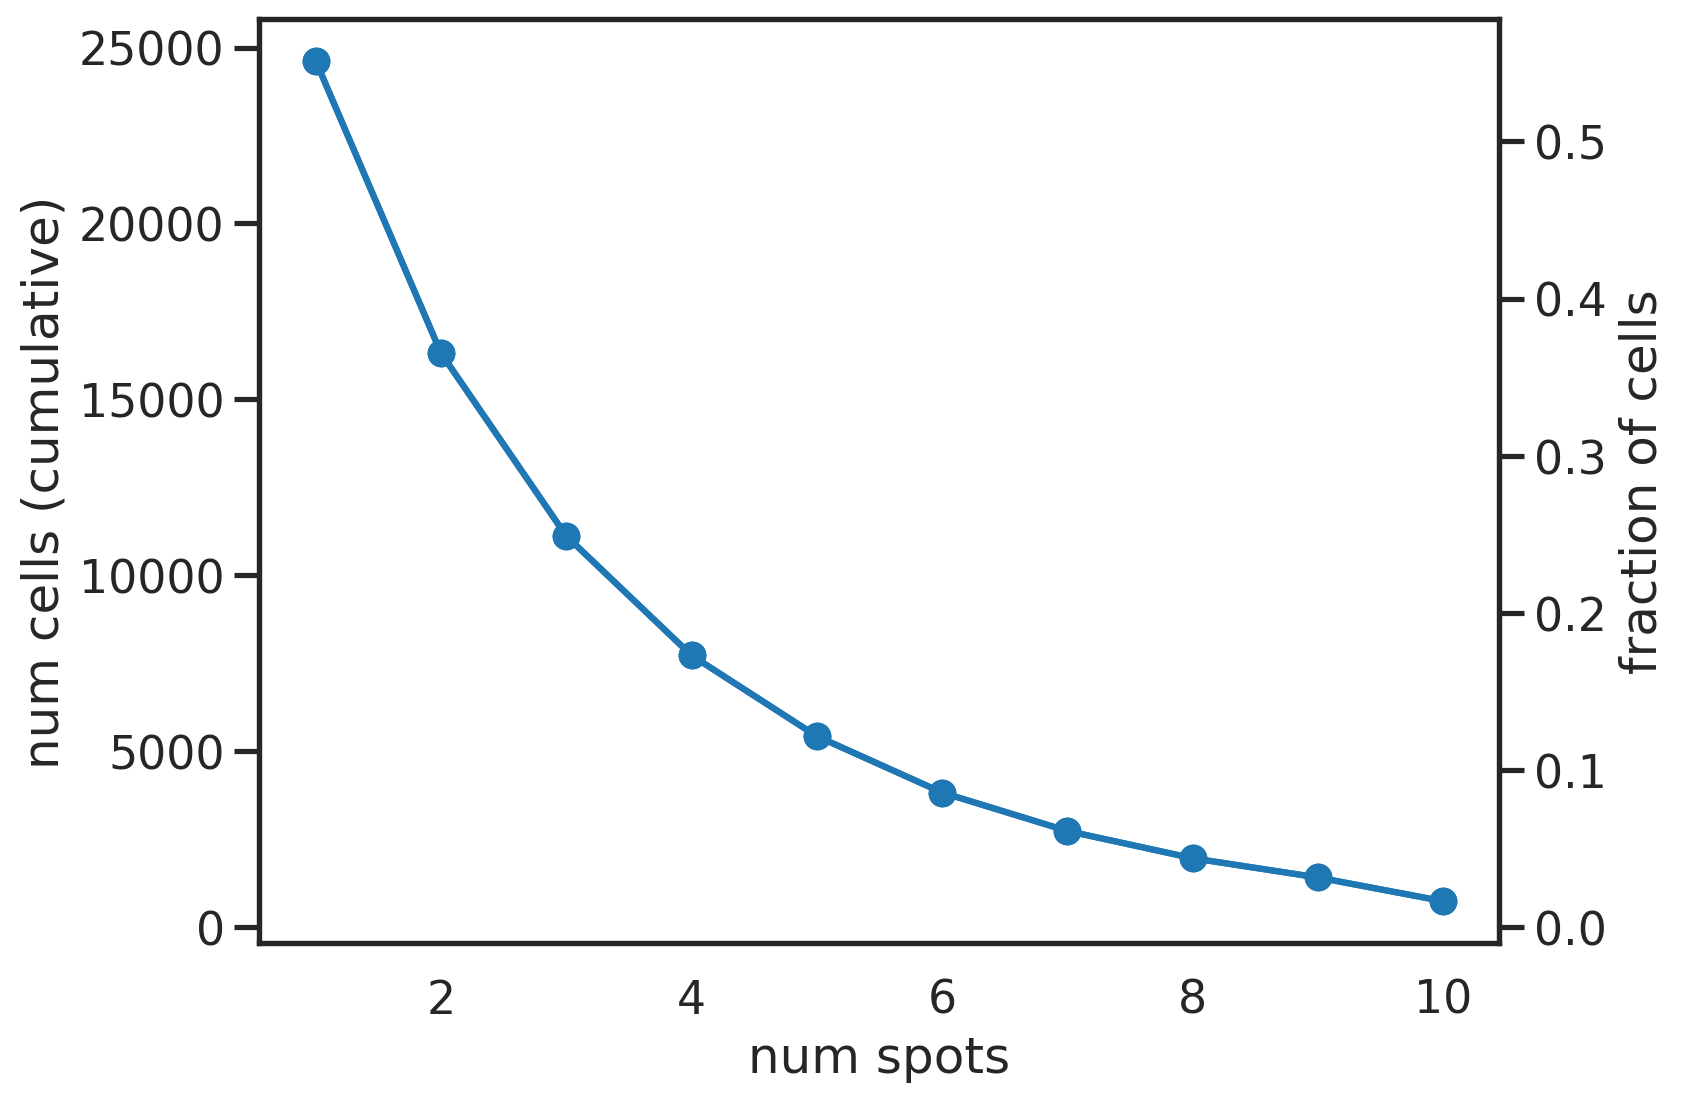

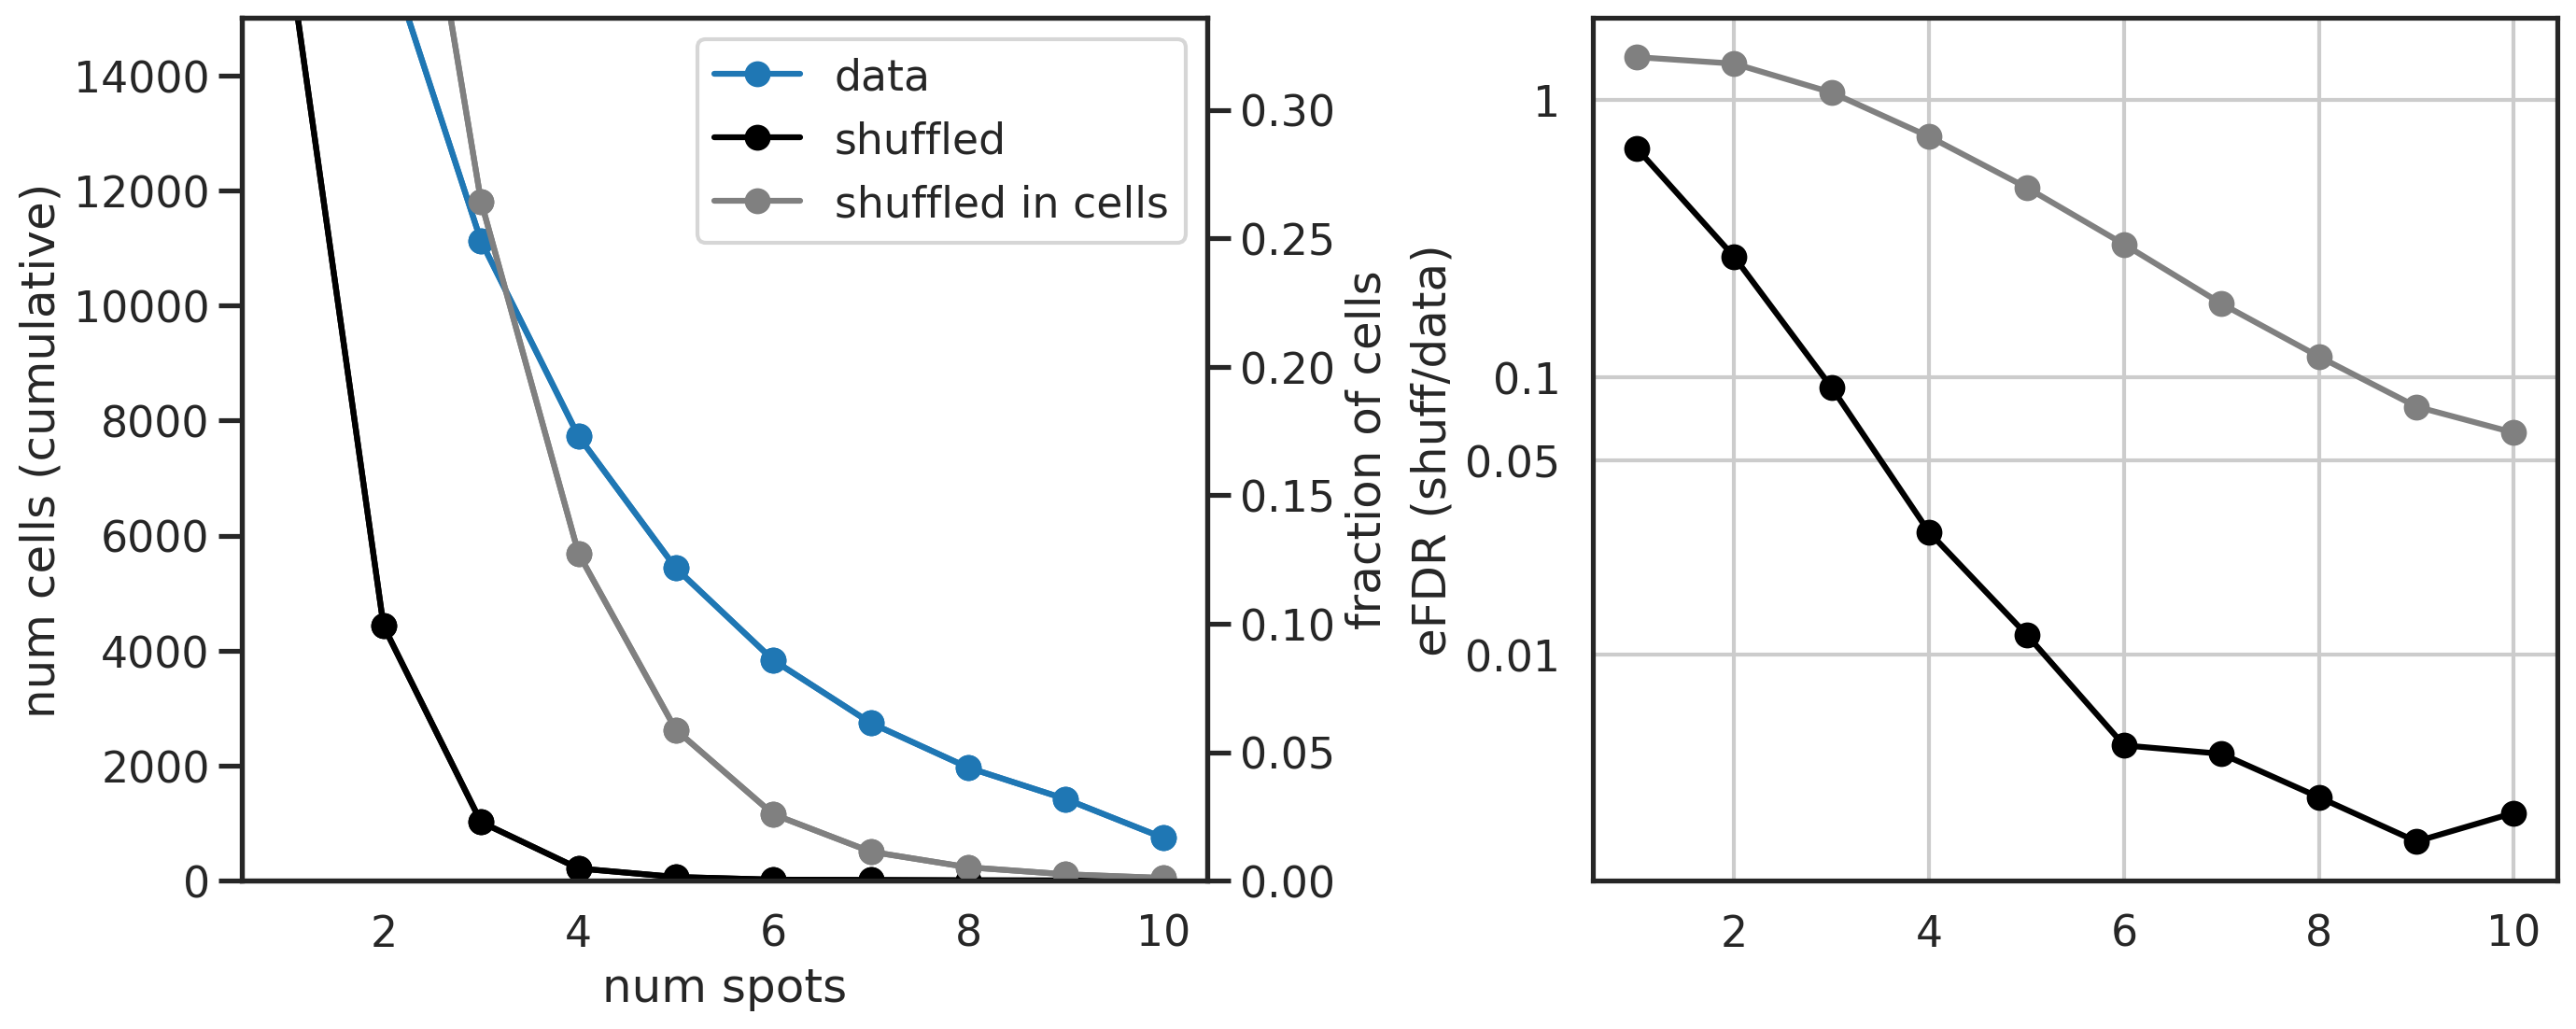

In [22]:
counts = res.values
counts_shuff  = res_shuff.values
counts_shuff2 = res_shuff2.values

fig = plot_reverse_cumsum(counts)
plt.show()

fig, axs = plot_reverse_cumsum_complex([counts, counts_shuff, counts_shuff2], 
                                label_list=['data', 'shuffled', 'shuffled in cells'],
                                color_list=['C0', 'black', 'gray'],
                                ymax=15000,
                               )
axs[0].legend()
plt.show()

In [23]:
table = roi_meta.join(spotcount) #_merged)
table

,z,y,x,area,r2v2_c0,r2v2_c1,r2v2_c2,r2v2_c4
roi,,,,,,,,
1,313.551073,192.570310,274.468272,6518.227968,3.0,106.0,10.0,3.0
2,406.512806,274.518986,512.783857,4150.677888,6.0,87.0,1.0,33.0
3,438.300452,668.782172,376.594839,3868.420416,4.0,86.0,2.0,3.0
4,444.097868,393.721313,446.610284,3854.911872,0.0,71.0,2.0,32.0
5,418.146478,153.725952,723.412235,4109.441280,4.0,47.0,3.0,36.0
...,...,...,...,...,...,...,...,...
44668,321.633139,420.395453,336.482922,1732.648512,4.0,21.0,1.0,2.0
44669,176.471225,260.635505,449.071440,1056.510336,0.0,1.0,0.0,0.0
44670,359.302876,419.739225,615.543910,880.188288,0.0,0.0,0.0,0.0


In [24]:
cond = table['r1_c0']>=10

fig, axs = plt.subplots(1, 3, figsize=(3*8,1*6))
ax = axs[0]
g = ax.scatter(table['x'], table['y'], c='lightgray', s=1, edgecolor='none')
g = ax.scatter(table['x'][cond], table['y'][cond], c='red', s=3, edgecolor='none')
# fig.colorbar(g, shrink=0.3)
ax.set_aspect('equal')

ax = axs[1]
g = ax.scatter(table['x'], table['z'], c='lightgray', s=1, edgecolor='none')
g = ax.scatter(table['x'][cond], table['z'][cond], c='red', s=3, edgecolor='none')
# fig.colorbar(g, shrink=0.3)
ax.set_aspect('equal')

ax = axs[2]
g = ax.scatter(table['y'], table['z'], c='lightgray', s=1, edgecolor='none')
g = ax.scatter(table['y'][cond], table['z'][cond], c='red', s=3, edgecolor='none')
# fig.colorbar(g, shrink=0.3)
ax.set_aspect('equal')
plt.show()

KeyError: 'r1_c0'

In [ ]:

for i in [1,2,5,8,10]:
    cond = table['r1_c2']>=i
    
    fig, axs = plt.subplots(1, 3, figsize=(3*8,1*6))
    fig.suptitle(f">= {i} spots (n={cond.sum()})")
    ax = axs[0]
    g = ax.scatter(table['x'], table['y'], c='lightgray', s=1, edgecolor='none')
    g = ax.scatter(table['x'][cond], table['y'][cond], c='red', s=3, edgecolor='none')
    # fig.colorbar(g, shrink=0.3)
    ax.set_aspect('equal')

    ax = axs[1]
    g = ax.scatter(table['x'], table['z'], c='lightgray', s=1, edgecolor='none')
    g = ax.scatter(table['x'][cond], table['z'][cond], c='red', s=3, edgecolor='none')
    # fig.colorbar(g, shrink=0.3)
    ax.set_aspect('equal')

    ax = axs[2]
    g = ax.scatter(table['y'], table['z'], c='lightgray', s=1, edgecolor='none')
    g = ax.scatter(table['y'][cond], table['z'][cond], c='red', s=3, edgecolor='none')
    # fig.colorbar(g, shrink=0.3)
    ax.set_aspect('equal')
    plt.show()


# check - c2

In [ ]:
i = 1
c = chs[i]
f_spots = fx_spots[i]
intn_th = intn_threshs[i]
print(r, c, f_spots) #, f_intns)

# spots
spots_rc = np.loadtxt(f_spots, delimiter=',')
print(len(spots_rc))

# filter
filter_cond = spots_rc[:,3] > intn_th
spots_rc = spots_rc[filter_cond]
print(len(spots_rc))

In [ ]:
spots = np.round(spots_rc[:,:3]/lb_res).astype(int)-1
spots_lb = lb[spots[:,2], spots[:,1], spots[:,0]] # z, y, x
spots_lb_outside = (spots_lb == 0)
print(f"fraction of spots outside of cells: {spots_lb_outside.sum()/len(spots):.2f}")
print(f"fraction of space outside of cells: {np.sum(lb==0)/lb.size:.2f}")

In [ ]:
%%time
# shuffle everywhere
lb_shuff = lb.copy()
np.random.shuffle(np.ravel(lb_shuff))
lb_shuff = lb_shuff.reshape(lb.shape)

In [ ]:
%%time
# shuffle in cells
i, j, k = lb.nonzero()
v = lb[i,j,k]
np.random.shuffle(v)
lb_shuff2 = np.zeros(lb.shape)
lb_shuff2[i,j,k] = v

In [ ]:
res        = spot.spot_counts_worker(lb, spots_rc, lb_res,
                              lb_id=lb_id, 
                              remove_noncell=True, 
                              selected_roi_list=lb_id_selected,
                              )
res_shuff  = spot.spot_counts_worker(lb_shuff, spots_rc, lb_res,
                              lb_id=lb_id, 
                              remove_noncell=True, 
                              selected_roi_list=lb_id_selected,
                              )
res_shuff2 = spot.spot_counts_worker(lb_shuff2, spots_rc, lb_res,
                              lb_id=lb_id, 
                              remove_noncell=True, 
                              selected_roi_list=lb_id_selected,
                              )

In [ ]:
plt.scatter(spots_rc[:,0]/ex, spots_rc[:,1]/ex, s=1, edgecolor='none')
plt.gca().set_aspect('equal')

In [ ]:
plt.scatter(spots_rc[:,0]/ex, spots_rc[:,2]/ex, s=1, edgecolor='none')
plt.gca().set_aspect('equal')

In [ ]:
plt.scatter(spots_rc[:,1]/ex, spots_rc[:,2]/ex, s=1, edgecolor='none')
plt.gca().set_aspect('equal')

In [ ]:
counts = res.values
counts_shuff  = res_shuff.values
counts_shuff2 = res_shuff2.values

fig = plot_reverse_cumsum(counts)
plt.show()

fig, axs = plot_reverse_cumsum_complex([counts, counts_shuff, counts_shuff2], 
                                label_list=['data', 'shuffled', 'shuffled in cells'],
                                color_list=['C0', 'black', 'gray'],
                                ymax=15000,
                               )
axs[0].legend()
plt.show()

In [ ]:
table = roi_meta.join(spotcount) #_merged)
table

In [ ]:
cond = table['r1_c2']>=5

fig, axs = plt.subplots(1, 3, figsize=(3*8,1*6))
ax = axs[0]
g = ax.scatter(table['x'], table['y'], c='lightgray', s=1, edgecolor='none')
g = ax.scatter(table['x'][cond], table['y'][cond], c='red', s=3, edgecolor='none')
# fig.colorbar(g, shrink=0.3)
ax.set_aspect('equal')

ax = axs[1]
g = ax.scatter(table['x'], table['z'], c='lightgray', s=1, edgecolor='none')
g = ax.scatter(table['x'][cond], table['z'][cond], c='red', s=3, edgecolor='none')
# fig.colorbar(g, shrink=0.3)
ax.set_aspect('equal')

ax = axs[2]
g = ax.scatter(table['y'], table['z'], c='lightgray', s=1, edgecolor='none')
g = ax.scatter(table['y'][cond], table['z'][cond], c='red', s=3, edgecolor='none')
# fig.colorbar(g, shrink=0.3)
ax.set_aspect('equal')
plt.show()

In [ ]:

for i in [1,2,5,8,10]:
    cond = table['r1_c2']>=i
    
    fig, axs = plt.subplots(1, 3, figsize=(3*8,1*6))
    fig.suptitle(f">= {i} spots (n={cond.sum()})")
    ax = axs[0]
    g = ax.scatter(table['x'], table['y'], c='lightgray', s=1, edgecolor='none')
    g = ax.scatter(table['x'][cond], table['y'][cond], c='red', s=3, edgecolor='none')
    # fig.colorbar(g, shrink=0.3)
    ax.set_aspect('equal')

    ax = axs[1]
    g = ax.scatter(table['x'], table['z'], c='lightgray', s=1, edgecolor='none')
    g = ax.scatter(table['x'][cond], table['z'][cond], c='red', s=3, edgecolor='none')
    # fig.colorbar(g, shrink=0.3)
    ax.set_aspect('equal')

    ax = axs[2]
    g = ax.scatter(table['y'], table['z'], c='lightgray', s=1, edgecolor='none')
    g = ax.scatter(table['y'][cond], table['z'][cond], c='red', s=3, edgecolor='none')
    # fig.colorbar(g, shrink=0.3)
    ax.set_aspect('equal')
    plt.show()
